# Determinação de parâmetros usando o algorítmo genético *stochastic differential evolution* e o modelo compartimental SEIAR

In [1]:
# basic modules
import numpy as np
import matplotlib.pylab as plt
from scipy.special import erf
import pandas as pd
from scipy.integrate import odeint

## Dados de cidades brasileiras 
A figura é criada assumindo que os casos começaram simultaneamente em todas as cidades

In [ ]:
BrC = pd.read_csv('https://github.com/wcota/covid19br/raw/master/cases-brazil-cities-time.csv',\
                  names=['date','country','state','city','ibgeID','newCases','totalCases']) 
BH = BrC[BrC['city'].str.match('Belo Horizonte')]
RJ = BrC[BrC['city'].str.match('Rio de Janeiro')]
SP = BrC[BrC['city'].str.match('São Paulo')]
BH_cases = pd.to_numeric(BH.totalCases)
BH_date  = pd.to_datetime(BH.date)
BH_days  = np.arange(0,len(BH_cases))
RJ_cases = pd.to_numeric(RJ.totalCases)
RJ_date  = pd.to_datetime(RJ.date)
RJ_days  = np.arange(0,len(RJ_cases))
SP_cases = pd.to_numeric(SP.totalCases)
SP_date  = pd.to_datetime(SP.date)
SP_days  = np.arange(0,len(SP_cases))

In [ ]:
%matplotlib notebook
plt.plot(BH_days,BH_cases,'-o',label='BH', color='r')
plt.plot(RJ_days,RJ_cases,'-o',label='RJ', color='b')
plt.plot(SP_days,SP_cases,'-o',label='SP', color='g')
plt.xlabel(r'$t$ days')
plt.ylabel('Casos confirmados')
plt.legend()
plt.yscale('log')

In [2]:
raw_deaths    = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
raw_confirmed = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
raw_recovered = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'

confirmed = pd.read_csv(raw_confirmed)
deaths    = pd.read_csv(raw_deaths)
recovered = pd.read_csv(raw_recovered)

time = confirmed.columns[4:]
def get_timeseries(country):
  cc = confirmed[confirmed['Country/Region']==country].iloc[:,4:].values
  dd = deaths[deaths['Country/Region']==country].iloc[:,4:].values
  rr = recovered[recovered['Country/Region']==country].iloc[:,4:].values
  return np.array([cc[0,:],dd[0,:],rr[0,:]])

In [3]:
Italy = get_timeseries('Brazil')
Italy_days = np.arange(0,len(Italy[0,:]))

## SEIAR model

In [4]:
def sird_func(x, t, *args):
    
    S,E,I,A,R,D = x
    N, beta, gamma, mu, theta, Z, D, alpha, m, n = args
    
    dSdt = -beta*S*I/N - mu*beta*S*A/N  + theta*m*S/(N-I) - theta*n*S/(N-I)
    dEdt =  beta*S*I/N + mu*beta*S*A/N - E/Z - theta*m*E/(N-I) + theta*n*S/(N-I)
    dIdt =  alpha*E/Z - I/D - gamma*I
    dAdt =  (1.-alpha)*E/Z - A/D - theta*m*A/(N-I) 
    dRdt =  I/(D) # + A/(D) - m*R
    dDdt =  gamma*I
    
    return dSdt,dEdt,dIdt,dAdt,dRdt,dDdt

In [5]:
def sird(args,tmin=0,tmax=120):
    
    N, beta, gamma, mu, theta, Z, D, alpha, m, n = args

    nt = (tmax-tmin)      # time steps    
    t = np.linspace(tmin,tmax,nt)
    
    # Initial conditions
    
    x0 = N, 20., 1., 6., 0., 0.
    sol = odeint(sird_func,x0,t,args=(N, beta, gamma, mu, theta, Z, D, alpha, m, n))
    Re = alpha*beta*D + (1.-alpha)*mu*beta*D
        
    return sol[:,0], sol[:,1], sol[:,2], sol[:,3], sol[:,4],sol[:,5], Re, t

In [6]:
# Root mean square error
def rmse(args,estado=Italy):
    tmin = 35
    tmax = len(estado[0,:])
    y = estado
    s, e, i, a, r, d, R0, t = sird(args,tmin,tmax)
    SdI = sum((y[0,int(tmin):] - i)**2) / len(y[0,int(tmin):])
    SdD = sum((y[1,int(tmin):] - d)**2) / len(y[1,int(tmin):])
    SdR = sum((y[2,int(tmin):] - r)**2) / len(y[2,int(tmin):])
    return np.sqrt(SdI+SdD+SdR)

In [7]:
N = 1.44e6
beta=1.2
gamma = 0.02
mu=0.5
Z= 3.69
D=3.48
alpha=0.15
theta = 3.
m=0.
n=0.
tmin = 35
args = N, beta, gamma, mu, theta, Z, D, alpha, m, n
sO, eO, iO, aO, rO, dO, R0, t = sird(args,tmin,100)
rmse(args)

1600.2658463206953

In [42]:
from scipy.optimize import differential_evolution
#x = []
#for nsamples in range(30):
bounds = [(2.e6, 20.e6),(0.5,2.5),(0.01,0.3),(0.5,0.5),(0.0,0.0),(5.2,5.2),(2.,10.),(0.01,0.6),(0,0),(0,0)]
results = differential_evolution(rmse,bounds,strategy='rand1bin',tol=0.001)
#    x.append(results.x)

/usr/local/lib/python3.6/dist-packages/scipy/optimize/_differentialevolution.py:750: RuntimeWarning: invalid value encountered in true_divide
  return (parameters - self.__scale_arg1) / self.__scale_arg2 + 0.5


In [43]:
results.x

array([2.07445973e+06, 1.58541177e+00, 1.00000000e-02, 5.00000000e-01,
       0.00000000e+00, 5.20000000e+00, 1.00000000e+01, 8.56458388e-02,
       0.00000000e+00, 0.00000000e+00])

In [44]:
sO, eO, iO, aO, rO, dO, R0, t = sird(results.x,tmin,420)
print(R0)

8.605978443260977


<IPython.core.display.Javascript object>


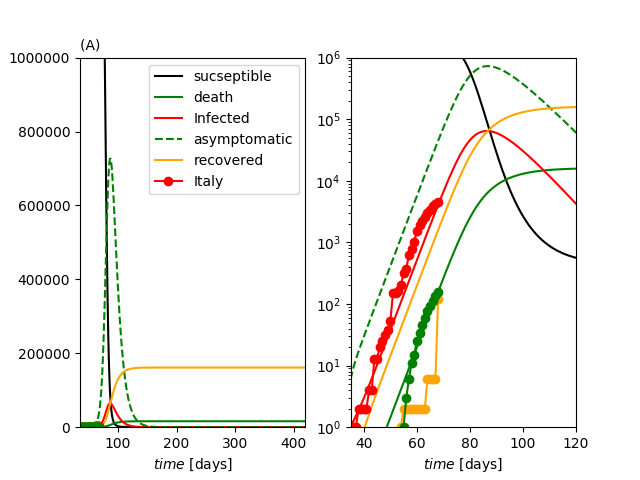

Text(0.5, 0, '$time$ [days]')

In [45]:
%matplotlib notebook


fig, ax = plt.subplots(1,2)
ax[0].set_title('(A) ',fontsize=10,loc='left')
ax[0].plot(t,sO,label='sucseptible',c='k')
ax[0].plot(t,dO,label='death',c='g')
ax[0].plot(t,iO,label='Infected', c='r')
ax[0].plot(t,aO,label='asymptomatic',c='g',linestyle='--')
ax[0].plot(t,rO,label='recovered',c='orange')
ax[0].plot(Italy_days,Italy[0,:],'-o',label='Italy', color='r')
ax[0].plot(Italy_days,Italy[2,:],'-o', color='orange')
ax[0].plot(Italy_days,Italy[1,:],'-o', color='green')

ax[0].set_xlabel(r'$time$ [days]')
xmin=35
xmax=420
ymin = 0
ymax = 1e6
ax[0].set_xlim(xmin,xmax)
ax[0].set_ylim(ymin,ymax)
plt.yscale('log')
ax[0].legend()

ax[1].plot(t,sO,label='sucseptible',c='k')
ax[1].plot(t,dO,label='death',c='g')
ax[1].plot(t,iO,label='Infected', c='r')
ax[1].plot(t,aO,label='asymptomatic',c='g',linestyle='--')
ax[1].plot(t,rO,label='recovered',c='orange')
ax[1].plot(Italy_days,Italy[0,:],'-o',label='BH', color='r')
ax[1].plot(Italy_days,Italy[2,:],'-o', color='orange')
ax[1].plot(Italy_days,Italy[1,:],'-o', color='green')



ymin=1e0
ymax=1e6
xmin=35
xmax=120
ax[1].set_ylim(ymin,ymax)
ax[1].set_xlim(xmin,xmax)

ax[1].set_xlabel(r'$time$ [days]')

In [ ]:
from scipy.optimize import differential_evolution
def ackley(x):
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e

bounds = [(-5, 5), (-5, 5)]
result = differential_evolution(ackley, bounds)
result.x, result.fun

In [ ]:
fobj = lambda x: x**2
bounds = [(-100,100)]
result = differential_evolution(fobj,bounds)
result

In [ ]:

%matplotlib inline
x = np.linspace(0, 10, 500)
y = np.cos(x) + np.random.normal(0, 0.2, 500)
plt.scatter(x, y)
plt.plot(x, np.cos(x), label='cos(x)')
plt.legend()


In [ ]:
differential_evolution?

In [ ]:
def fmodel(x, w):
    return w[0] + w[1]*x + w[2] * x**2 + w[3] * x**3 + w[4] * x**4 + w[5] * x**5

In [ ]:
def rmse2(w):
    y_pred = fmodel(x, w)
    return np.sqrt(sum((y - y_pred)**2) / len(y))

In [ ]:
bounds = [(-5, 5)] * 6
result = differential_evolution(rmse2,bounds,maxiter=3000)

In [ ]:
plt.plot(x, np.cos(x), label='cos(x)')
plt.plot(x, fmodel(x,result.x),'--')

In [ ]:
differential_evolution?

In [ ]:
BrC = pd.read_csv('covid19-06577ef970e940388c14bf7b36ef33f9.csv')

In [ ]:
%matplotlib notebook
plt.plot(BrC.confirmed)

In [ ]:
BH = BrC[BrC['city'].str.match('Belo Horizonte')]
RJ = BrC[BrC['city'].str.match('Rio de Janeiro')]
SP = BrC[BrC['city'].str.match('São Paulo')]

In [ ]:
SP

In [ ]:
BH_cases

In [ ]:
differential_evolution?

In [ ]:
Italy[0,34:]